# Research Hypothesis:
<b>A detector using ARIMA does better than simple moving averages when detecting unusual patterns in email traffic to email traffic to non-organizational accounts.</b>

For this research, we leverage CERT data. CERT data is synthetic and was constructed by ExactData, LLC and the CERT division of CMU (https://www.cert.org/insider-threat/tools/). The dataset version r6.2.tar.bz2 was analyzed.

## Quick section on just some collected, random thoughts

Once anomalies are identified, how do we interpret the different types of anomalies?
    - Mean shift (rapid transition to new mean)
        - Indicator they are rapidly communicating with competitor
        - Indicator they are quickly leaking IP
    - Ramp up (slow transition to new mean)
        - Indicator they are slowly beginning to communicate with competitor
        - Indicator they are quickly leaking IP

Proportion of emails to outside is probaby small compared to inside traffic (how small is this?)

In addition to unusual traffic, we should also look at unusual send time. However, CERT suggests
most IP is leaked during normal work hours.

Can we obtain a list of competitor accounts from organization?

Sending to a new non-org account, even for first time, is interesting.

## Import Python Packages

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import itertools
import numpy.ma as ma
from statsmodels.tsa.arima_model import ARIMA
import warnings
from numpy.linalg import LinAlgError

/Users/MattJohnson/Development/git/long-range-extrapolation/.pythonenv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## The Email Dataset

CERT provides a description below of the their provided email data:

CERT provides a description below of the different scenarios that are modeled:

Below are the insiders that correspond to an insider user scenario of "CDE1846", but it also contains 157 other users:

The dataset loaded below is a subset (for computional convenience). It contains the insider "CDE1846" along with 157 non-insiders.

In [2]:
df = pd.read_csv('../../data/email_filtered.csv', parse_dates=['date'])

In [3]:
df.head()

,id,date,user,pc,to,cc,bcc,from,activity,size,attachments,content
0,{D0V4-N9KM15BF-0512LLVP},2010-01-04 07:36:48,BTR2026,PC-9562,Thaddeus.Brett.Daniel@dtaa.com,Zorita.Angela.Wilson@dtaa.com,NaN,Beau.Todd.Romero@dtaa.com,Send,23179,NaN,"On November 25, general Savary was sent to the..."
1,{L5E5-J1HB80OY-9539AOEC},2010-01-04 07:38:18,BTR2026,PC-9562,Beau.Todd.Romero@dtaa.com,NaN,NaN,Marsh_Travis@raytheon.com,View,17047,NaN,"Early in the morning of May 27, a boat crossed..."
2,{Q4V7-V6BR00TZ-5209UVDX},2010-01-04 07:53:35,BTR2026,PC-9562,Bianca-Clark@optonline.net,NaN,NaN,Beau_Romero@aol.com,Send,26507,NaN,The Americans never held up their side of the ...
3,{Q0S5-G9FU80DK-0356YZID},2010-01-04 07:59:19,BTR2026,PC-9562,Beau.Todd.Romero@dtaa.com,NaN,NaN,Lunea.Evelyn.Massey@dtaa.com,View,20891,NaN,"General Arnold, who was meeting with the retre..."
4,{C3U3-I4CT54EL-4597MPWW},2010-01-04 08:00:58,BTR2026,PC-9562,Beau.Todd.Romero@dtaa.com,NaN,NaN,Holman-Yardley@harris.com,View,29753,NaN,"Man the divine manifestation effectively dies,..."


In [4]:
# The insider
df_insider = df[df['user'] =='CDE1846']
df_insider

,id,date,user,pc,to,cc,bcc,from,activity,size,attachments,content
9,{H4R6-U0EC95ZE-4584YYEM},2010-01-04 13:01:14,CDE1846,PC-1237,Ashley-Finn@comcast.net,Edward-Curtis@bellsouth.net,Ewing_Carlos@comcast.net,Ewing_Carlos@comcast.net,Send,1058059,C:\KL5P0DHC.txt(1036651),"In 1937, The Times described the half-mile bet..."
10,{V3O9-Q2PD59GF-8779BWTB},2010-01-04 13:01:46,CDE1846,PC-1237,Carlos.Dieter.Ewing@dtaa.com,NaN,NaN,Stephen.Ferris.Montoya@dtaa.com,View,32238,NaN,An Ohio School Facilities Assessment in 2002 r...
11,{M3B1-I9DN95IL-9836XHQK},2010-01-04 13:08:27,CDE1846,PC-1237,Edward-Curtis@bellsouth.net,Ewing_Carlos@comcast.net,NaN,Ewing_Carlos@comcast.net,Send,44032,NaN,"To the north, two volcanoes form a sparse area..."
12,{A4F3-N8RI14LU-3305OWVQ},2010-01-04 13:13:22,CDE1846,PC-1237,Carlos.Dieter.Ewing@dtaa.com,NaN,NaN,Tamara_Sexton@harris.com,View,30448,NaN,"In all, the Justice Department task force secu..."
13,{I4D7-I5YY55UW-2126SGPH},2010-01-04 13:13:46,CDE1846,PC-1237,Carlos.Dieter.Ewing@dtaa.com,NaN,NaN,Malcolm.Timothy.Nielsen@dtaa.com,View,48777,NaN,The Democrats on the Senate committee publishe...
14,{T1B1-L8ZE40DC-8153KPWM},2010-01-04 13:13:46,CDE1846,PC-1237,Shaw-Quincy@earthlink.net;JHK841@bellsouth.net...,Zephr_A_Collier@yahoo.com,Ewing_Carlos@comcast.net,Ewing_Carlos@comcast.net,Send,19688,NaN,"The furniture in the hall was designed by, and..."
15,{G9A1-K1VO47KR-2765BQPM},2010-01-04 13:14:06,CDE1846,PC-1237,Carlos.Dieter.Ewing@dtaa.com,NaN,NaN,RCC7422@northropgrumman.com,View,29158,NaN,It's a lot of things strung together that pain...
16,{N8X9-H8JJ82NM-5606NSOZ},2010-01-04 13:17:31,CDE1846,PC-1237,Carlos.Dieter.Ewing@dtaa.com,NaN,NaN,Carl.Alfonso.Roman@dtaa.com,View,39711,NaN,The line of volcanoes has been the subject of ...
17,{K6T9-W5TE97FD-9058TBDC},2010-01-04 13:22:49,CDE1846,PC-1237,Carlos.Dieter.Ewing@dtaa.com,NaN,NaN,EDA1416@boeing.com,View,29208,NaN,"The tower was completed in 1956, and the colle..."
52,{T9O4-O7UF16YT-4710JANO},2010-01-05 14:42:37,CDE1846,PC-1237,Diana.Colette.Clayton@dtaa.com;Ralph.Aladdin.B...,Imogene.Charde.Hicks@dtaa.com;Ursa.Melinda.Ben...,NaN,Cole.Nicolas.Knight@dtaa.com,View,30266,NaN,"As a result, in June 1924 the navy's gunnery s..."


In [5]:
df_insider.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3165 entries, 9 to 11910
Data columns (total 12 columns):
id             3165 non-null object
date           3165 non-null datetime64[ns]
user           3165 non-null object
pc             3165 non-null object
to             3165 non-null object
cc             1997 non-null object
bcc            519 non-null object
from           3165 non-null object
activity       3165 non-null object
size           3165 non-null int64
attachments    1274 non-null object
content        3165 non-null object
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 321.4+ KB


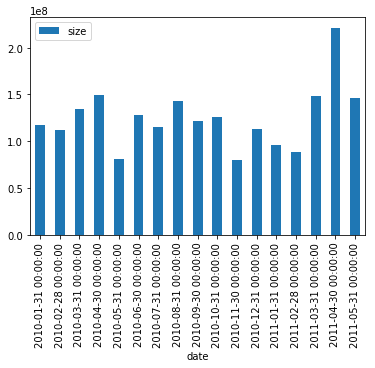

In [6]:
# Plot a cumulative sum of total email size sent out each month
df_insider.resample(rule='1M', on='date').sum().plot(kind='bar')

In [7]:
# Plot a cumulative sum of total email size sent out each month
# But also, focus on emails sent to non-org accounts
df_insider_non_org = df_insider[~df_insider['to'].str.contains('dtaa.com')]
df_insider_non_org

,id,date,user,pc,to,cc,bcc,from,activity,size,attachments,content
9,{H4R6-U0EC95ZE-4584YYEM},2010-01-04 13:01:14,CDE1846,PC-1237,Ashley-Finn@comcast.net,Edward-Curtis@bellsouth.net,Ewing_Carlos@comcast.net,Ewing_Carlos@comcast.net,Send,1058059,C:\KL5P0DHC.txt(1036651),"In 1937, The Times described the half-mile bet..."
11,{M3B1-I9DN95IL-9836XHQK},2010-01-04 13:08:27,CDE1846,PC-1237,Edward-Curtis@bellsouth.net,Ewing_Carlos@comcast.net,NaN,Ewing_Carlos@comcast.net,Send,44032,NaN,"To the north, two volcanoes form a sparse area..."
14,{T1B1-L8ZE40DC-8153KPWM},2010-01-04 13:13:46,CDE1846,PC-1237,Shaw-Quincy@earthlink.net;JHK841@bellsouth.net...,Zephr_A_Collier@yahoo.com,Ewing_Carlos@comcast.net,Ewing_Carlos@comcast.net,Send,19688,NaN,"The furniture in the hall was designed by, and..."
56,{H9Y9-I4CJ02FM-5301ZJZZ},2010-01-05 15:56:16,CDE1846,PC-1237,Huff.John@sbcglobal.net;Hull_Carl@netzero.com,Ewing_Carlos@comcast.net,NaN,Noelani_Miles@comcast.net,View,30839,NaN,Nixon family friend and Whittier College trust...
60,{H8Q9-N9JC95JX-2406TNRP},2010-01-05 16:01:39,CDE1846,PC-1237,Jimenez-Baxter@yahoo.com;CNK8@verizon.net,CEM5@aol.com;Zephr_A_Collier@yahoo.com,Ewing_Carlos@comcast.net,Ewing_Carlos@comcast.net,Send,37076,NaN,This was the second largest plane factory in G...
62,{F4I1-L2NW66KI-9518PHXO},2010-01-05 16:03:00,CDE1846,PC-1237,Edward-Curtis@bellsouth.net,Ewing_Carlos@comcast.net,NaN,Ewing_Carlos@comcast.net,View,44032,NaN,"To the north, two volcanoes form a sparse area..."
76,{Z2K8-K2MY03MM-9801HWNN},2010-01-06 10:19:45,CDE1846,PC-1237,Shaw-Quincy@earthlink.net,NaN,Ewing_Carlos@comcast.net,Ewing_Carlos@comcast.net,Send,49015,NaN,"The remaining ""vestiges"" of the first plan, he..."
104,{X3B5-Z3FK85XK-7048IOBI},2010-01-07 12:15:21,CDE1846,PC-1237,Noelani_Miles@comcast.net;Edward-Curtis@bellso...,Ashley-Finn@comcast.net,NaN,Ashley-Finn@comcast.net,View,25083,NaN,A soldier in a specific Job always has its inn...
115,{X9Y3-N9EL87PD-8386AKSW},2010-01-07 16:03:00,CDE1846,PC-1237,Shaw-Quincy@earthlink.net,NaN,NaN,Ewing_Carlos@comcast.net,View,49015,NaN,"The remaining ""vestiges"" of the first plan, he..."
119,{Z3F1-P2SB95VF-6007XRUY},2010-01-07 16:34:00,CDE1846,PC-1237,Jimenez-Baxter@yahoo.com;CNK8@verizon.net,CEM5@aol.com;Zephr_A_Collier@yahoo.com,NaN,Ewing_Carlos@comcast.net,View,37076,NaN,This was the second largest plane factory in G...


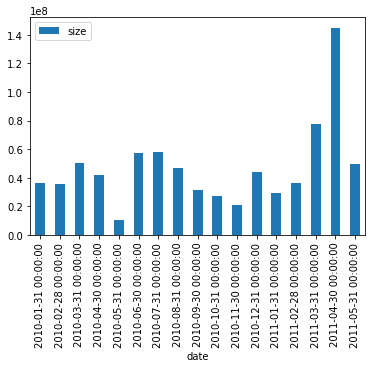

In [8]:
# Let's look at cumulative size of emails to non-org account per month
df_insider_non_org.resample('1M', on='date').sum().plot(kind='bar')

# Exploring The Insider Threat Case In Detail

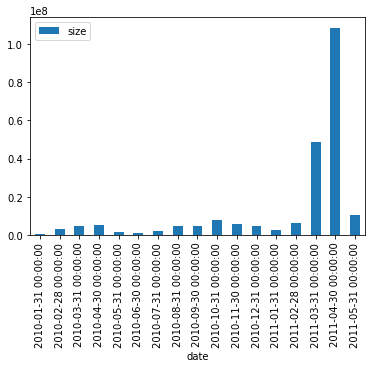

In [9]:
# Here, we look at the case where the insider emailed IP to their home account
# The data is resampled per month and now, the anomalous behavior is clearly
# visible
df_insider_ewing = df_insider_non_org[df_insider_non_org['to'] == 'Ewing_Carlos@comcast.net']
df_insider_ewing.resample('1M', on='date').sum().plot(kind='bar')

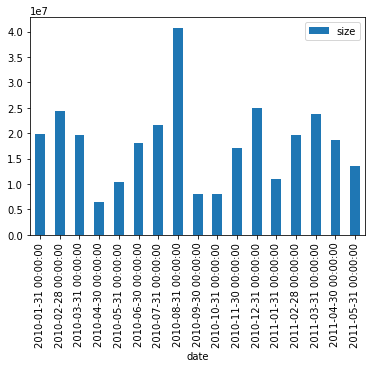

In [10]:
# For comparison, a look at a non-insider
df_noninsider = df[df['user'] =='BTR2026']
df_noninsider = df_noninsider[~df_noninsider['to'].str.contains('dtaa.com')]
df_noninsider.resample('1M', on='date').sum().plot(kind='bar')

# ARIMA
ARIMA is mostly time series analysis. It's purpose is to forecast future points. The simplest is a univariate time series. Here, we have $y(t)$. Our goal is to create a model $\hat{y}(t)$ and use it to estimate $y(t+1)$. ARIMA is an acronym for Autoregressive integrated moving average and is comprised of three parts: 

1. Autoregressive Process - AR(p)
2. Differencing - I(d)
3. Moving Average Process - MA(q)

Each of these parts are explained in more detail below, but each part comes with a an integer parameter that must be specified. That is, p, d, q. Together: AR(p) + I(d) + MA(q) = ARIMA(p,d,q)

## Autoregression Model

An autoregressive model assumes that future data points are linearly correlated with past data points:

$y(t) = \beta_0 + \beta_1 y_{t-1} + \epsilon_t$

$\beta_0$ is our bias term and $\beta_1$ measures the linear relationship of two adjacent points (assuming a constant sampling rate). $\epsilon_t \sim N(0, \sigma^2)$.

We refer to this as a AR(p) model. Here in this case, p=1 since we only use the previous point. This previous point is known as the "lag 1" variable. In general, we can incorporate as many lag variables as necessary that explain the data. A function can be defined that takes as input the lag index and outputs the coefficient of correlation (i.e., Pearson's). This function is known as the autocorrelation function or ACF for short.

## Moving Average Model

A moving average process models the data as having linear dependencies on previous error terms.

$y(t) = \mu + e_t + \theta_1 e_{t-1}$

Where here, $e_t \sim N(0, \sigma_e^2)$

$\mu$ is our bias term and $\theta_1$ measures the linear relationship of two adjacent points generated from a normal distribution (assuming a constant sampling rate).

We refer to this as a MA(q) model. Here in this case, q=1 since we only use the previous point. This previous point is  a "lag 1" variable. In general, we can incorporate as many lag variables as necessary that explain the data.

The mean of this model will be (for any q) will be $E[y] = \mu$. So this models a process that bounces back and forth around this mean value.

<b>Why are MA models important?</b>

First note, that these models are not smoothing the data as is done for a moving average. They seem to useful in impulse response, also known as "shocks". That is, there can be exogenous impulses that peturb our observed data. We'd like to model how these effects persist, and assume this persistence can be modeled as a linear relationship. Note that in the AR model, it's value is affected by a shock at time t. But by extending this dependency to previous shocks, we can model the persistence of shocks in the system.

One example is an earthquake. If there's an earthquake, it will negativetly affect economy for a time scale that extends into the future. This creates an impulse that a rapid effect on our y(t) variable. [http://www.econ.ohio-state.edu/dejong/note2.pdf]. So a MA is trying to learn an impulse-response function from data.

<b>Properties</b>

Apparently, a theoretical property of MA(q) models is that there will be nonzero autocorrelations for the first q lags, but 0 for all other lags. That is, the autocorrelations will not become significant again once it's zero.



<b>Questions</b>

Why MA(q) require maximum likelihood estimation?

A MA(q) can be expressed as a AR($\infty$) model? So perhaps, we can just fit a higher order AR(p) process and abandon MA model?

## Integrated

The I(d) process applies the order of differencing used. In order to use ARIMA, the process must be stationary (why?). One simple technique then, to detrend the data, is to introduce a new variable such as $y'(t) = y(t) - y(t-1)$ and subject this new variable to ARIMA. This differencing technique can be applied again on $y'(t)$. This would be a I(d=2) process.

## ARIMA Parameter Estimation
So how are ARIMA parameters estimated? The answer seems is by calculating the exact maximum likelihood via Kalman filtering (https://www.jstor.org/stable/2346910, https://www.stat.berkeley.edu/classes/s244/as154.pdf). This is what the statsmodels package in Python appears to use. Also, one can use the CSS log likelihood which trades accuracy for speed (https://stats.stackexchange.com/questions/160766/arima-fitting-css-vs-css-log-likelihood).

Once the parameters are estimated, the model can make predictions. In addition, the AIC value of the model can be calculated by:

$AIC = -2log(L) + 2(p + q + k + 1)$

where $L$ is the log likelihood of the data (calculated from Kalman). k is the number of parameters being fitted in the data (why do we repeat than p and q?).

AIC provides a way to perform a grid search using different values of p and q. 

## Confidence Intervals
The confidence intervals in ARIMA can be used to see if observed data points are within an expected range (e.g., a 95% confidence interval). The confidence interval is calculated as follows:

($\hat{y_t} - z_{\frac{\alpha}{2}} * SE, \hat{y_t} + z_{\frac{\alpha}{2}} * SE$)

$SE * z_{\frac{\alpha}{2}}$ is known as the margin of error. SE is the standard error and z is the z score. If the z score in this case is set to 1.96, this would correspond to an interval where if experiments were conducted an infinite amount of times, 95% of the observed data points would reside. This probability, however, is a conditional one. And assumes the data is in fact generated from this distribution. So how do we calculate the SE?

Any ARIMA model can be converted into a infinite order MA model [https://onlinecourses.science.psu.edu/stat510/node/66].

$y - \mu = e_t + \psi_1 e_{t-1} + ... + \psi_k e_{t-k} + ... = \sum_{j=0}^{\infty} \psi_j e_{t-j}$

Where we define $\psi_0 = 1$.

Now, suppose we know the values up to time n and we forecast m values out. The variance between the actual value at n+m and the predicted value at n+m is:

$Var = {\sigma_e}^2 \sum_{j=0}^{m-1} \psi_j^2$

And so the standard error is:

$SE = \sqrt{{\sigma_e}^2 \sum_{j=0}^{m-1} \psi_j^2}$

As the prediction horizon increases, SE will in general, increase.

But this confidence interval is under the condition that the residuals are normally distributed. The residuals should be checked (ACF plot?) and put in a histogram to check for normality. The ARIMA model is cast to a MA($\infty$) process.

# Running ARIMA

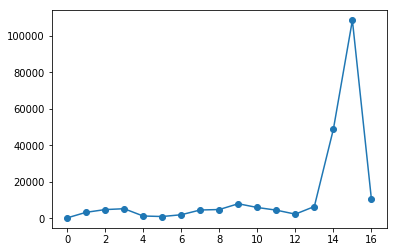

In [11]:
# Let's take the insider threat case
df_size = df_insider_ewing.resample('1M', on='date').sum()
y = df_size['size'].values.astype(np.float) / 1000.
plt.plot(y, marker='o')

Text(0.5,1,'One Month Lag')

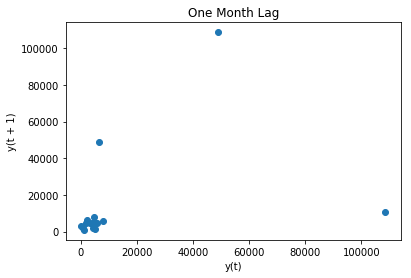

In [12]:
# We can view lab plots. This will
# help us visualize points at time t
# correlated with previous time points
from pandas.plotting import lag_plot
lag_plot(df_size['size'] / 1000., lag=1)
plt.title("One Month Lag")

Text(0.5,1,'Two Month Lag')

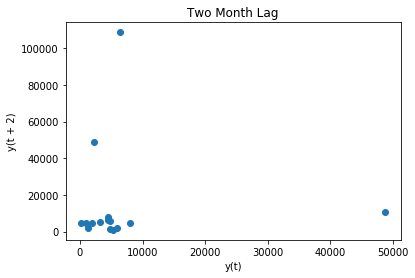

In [13]:
from pandas.plotting import lag_plot
lag_plot(df_size['size'] / 1000., lag=2)
plt.title("Two Month Lag")

In [14]:
def get_ARIMA_param_values(y):
    """ Get best ARIMA values given data
    """
    warnings.filterwarnings('ignore')
    
    # Values to try
    p = [0, 1, 2, 3]
    d = [0, 1, 2]
    q = [0, 1, 2, 3]
    results = []

    for pi, di, qi in itertools.product(p, d, q):
        try:
            model = ARIMA(y, order=(pi, di, qi))
            model_fit = model.fit()
            aic = model_fit.aic
            if not np.isnan(aic):
                results.append(((pi,di,qi), aic, model_fit))
        except ValueError:
            pass
        except LinAlgError:
            pass
    warnings.filterwarnings('default')
    return sorted(results, key=lambda x: x[1])[0]

In [15]:
# Example of how function works
get_ARIMA_param_values(y)

((0, 2, 1),
 362.21003003144165,
 <statsmodels.tsa.arima_model.ARIMAResultsWrapper at 0x115f27630>)

In this example, we will take the first 5 data points and forecast the next data point. Then, we will train on the first 6 datapoints, and forecast for the next, etc. We will plot the confidence intervals (95%) for this prediction.

In [16]:
def get_pred_and_conf(y, k=5):
    """
    k: First k points to learn from
       before making predictions
    """
    warnings.filterwarnings('ignore')

    k = 5

    # First 5 points won't have predictions
    pred = [np.nan] * k
    conf = [np.nan] * k

    # Let some historical points be available first
    assert k < len(y)
    for i in range(k, len(y)):

        # Historical data
        data = y[:i]

        # Params, AIC
        params, aic, model_fit = get_ARIMA_param_values(data)

        # Unpack params
        p, d, q = params

        # Make prediction
        forecast, stderr, conf_int = model_fit.forecast(steps=1, alpha=0.05)

        # Prediction of next time point
        y_t_1 = forecast[0]

        # Upper bound and lower bound
        # Just grab upper bound
        # That's all we need for matplotlib
        err = (conf_int[0][1] - y_t_1)
        # lower_bound = conf_int[0][0]

        pred.append(y_t_1)
        conf.append(err)

    warnings.filterwarnings('default')
    return pred, conf

In [17]:
# Now, let's plot results
pred, conf = get_pred_and_conf(y)

/Users/MattJohnson/Development/git/long-range-extrapolation/.pythonenv/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/MattJohnson/Development/git/long-range-extrapolation/.pythonenv/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/MattJohnson/Development/git/long-range-extrapolation/.pythonenv/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treate

/Users/MattJohnson/Development/git/long-range-extrapolation/.pythonenv/lib/python3.6/site-packages/numpy/core/numeric.py:492: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Text(0.5,1,'Total Size of Emails Sent By Month')

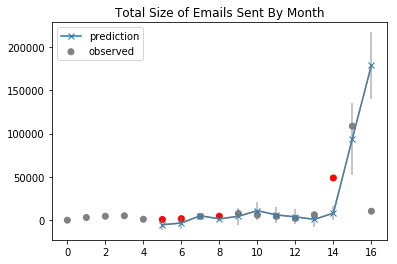

In [18]:
x = range(len(pred))

# Allows array to be multiplied by scalar
# even though np.nans are present
conf_masked = ma.masked_array(conf, mask=np.isnan(conf))

# Tolerance parameter
n = 2.

color_map = ['r' if yi > (y_hat + y_err) * n else 'gray' for yi, y_hat, y_err in zip(y, pred, conf)]
plt.scatter(x, y, marker='o', color=color_map, label='observed')
plt.plot(pred, marker='x', label='prediction')
plt.errorbar(x, pred, yerr=conf_masked * n, color='gray', alpha=0.6)
plt.legend(loc='upper left')
plt.title('Total Size of Emails Sent By Month')